# Topic modeling with LDA

This notebook implements LDA model for topic modeling on the training dataset. In particular, the choosen representation is BOW with the steps described in the classification notebook.

### Data loading

In [ ]:
import os
import csv
import numpy as np
import pandas as pd

In [ ]:
train_df = pd.read_csv("train_stockemo.csv", encoding="utf-8")
train_df

,id,date,ticker,emo_label,senti_label,original,processed
0,100001,2020-01-01,AMZN,excitement,bullish,$AMZN Dow futures up by 100 points already 🥳,Amazon Dow futures up by 100 points already [...
1,100002,2020-01-01,TSLA,excitement,bullish,$TSLA Daddy's drinkin' eArly tonight! Here's t...,Tesla Daddy's drinkin' eArly tonight! Here's t...
2,100003,2020-01-01,AAPL,confusion,bullish,$AAPL We’ll been riding since last December fr...,Apple We’ll been riding since last December fr...
3,100004,2020-01-01,TSLA,excitement,bullish,"$TSLA happy new year, 2020, everyone🍷🎉🙏","Tesla happy new year, 2020, everyone [wine gla..."
4,100005,2020-01-01,TSLA,excitement,bullish,"$TSLA haha just a collection of greats...""Mars...","Tesla haha just a collection of greats...""Mars..."
...,...,...,...,...,...,...,...
7995,109536,2020-08-06,AAPL,surprise,bullish,BREAKING NEWS: $AAPL beats Elon Musk and Richa...,BREAKING NEWS: Apple beats Elon Musk and Richa...
7996,109541,2020-08-10,AAPL,belief,bullish,$AAPL why be a 2T giant and not dabble a littl...,Apple why be a 2T giant and not dabble a littl...
7997,109561,2020-08-18,AMZN,ambiguous,bullish,"$AMZN - 3,500 jobs = $3,500 ??? 😁","Amazon - 3,500 jobs = $3,500 ??? [beaming fac..."
7998,109795,2020-10-01,TSLA,surprise,bullish,$TSLA $500c 10/2 at 36k volume 👀👀,Tesla $500c 10/2 at 36k volume [eyes]


In [ ]:
val_df = pd.read_csv("val_stockemo.csv", encoding="utf-8")
val_df

,id,date,ticker,emo_label,senti_label,original,processed
0,100595,2020-02-06,TSLA,anger,bearish,$TSLA did jim Cramer just pull another bear St...,Tesla did jim Cramer just pull another bear St...
1,100693,2020-02-11,FB,anger,bearish,$FB uh oh FTC turning up the heat 💩,Facebook uh oh FTC turning up the heat [pile ...
2,101203,2020-03-04,AAPL,anger,bullish,$AAPL why are they holding it here! WTF! ✌🏽 GL...,Apple why are they holding it here! WTF! [vic...
3,101223,2020-03-05,MSFT,belief,bullish,$MSFT 🍀🍀Target $200.00 long term ☀️☀️☀️☀️☀️,Microsoft [four leaf clover] Target $200.00 ...
4,101349,2020-03-11,AMZN,anger,bullish,$AMZN another RED day... thus is just plain ou...,Amazon another RED day... thus is just plain o...
...,...,...,...,...,...,...,...
995,108995,2020-12-31,TSLA,disgust,bullish,$TSLA What’s twice as good as $420? —————> $840 😎,Tesla What’s twice as good as $420? —————> $84...
996,108996,2020-12-31,FB,anxiety,bearish,$FB We’ll that’s some options fuckery by insti...,Facebook We’ll that’s some options fuckery by ...
997,108997,2020-12-31,TSLA,optimism,bullish,$TSLA the daily looks like a big ✅ check mark!...,Tesla the daily looks like a big [check mark ...
998,108998,2020-12-31,BA,optimism,bullish,"$BA this will pump when you least expect it, r...",Boeing this will pump when you least expect it...


In [ ]:
test_df = pd.read_csv("test_stockemo.csv", encoding="utf-8")
test_df

,id,date,ticker,emo_label,senti_label,original,processed
0,100067,2020-01-08,AAPL,confusion,bearish,$AAPL with all time highs again the market see...,Apple with all time highs again the market see...
1,100115,2020-01-10,BA,anxiety,bullish,$BA about to explode 🚨\nKeep shorting please,Boeing about to explode [police car light] \n...
2,100175,2020-01-15,SBUX,confusion,bearish,"$SBUX TPO alot of volume at 91.74, thats after...","Starbucks TPO alot of volume at 91.74, thats a..."
3,100234,2020-01-18,TSLA,confusion,bearish,$TSLA down 6$ afterhours right now 🤔,Tesla down 6$ afterhours right now [thinking ...
4,100268,2020-01-22,BA,confusion,bearish,$BA can someone tell me why they haven’t downg...,Boeing can someone tell me why they haven’t do...
...,...,...,...,...,...,...,...
995,109996,2020-12-31,ABNB,optimism,bearish,"$ABNB “sugar daddy puts.” Don’t mind me, I’m j...","Airbnb “sugar daddy puts.” Don’t mind me, I’m ..."
996,109997,2020-12-31,TSLA,disgust,bullish,$TSLA \nGood news... now bears can get help wh...,Tesla \nGood news... now bears can get help wh...
997,109998,2020-12-31,BABA,confusion,bullish,$BABA Who else is glad they sold in 240s yeste...,Alibaba Who else is glad they sold in 240s yes...
998,109999,2020-12-31,CCL,amusement,bullish,$CCL $23 calls for .79 you know what to do 🥳,Carnival $23 calls for .79 you know what to do...


In [ ]:
unique_ticker_train = set(train_df['ticker'].unique())
unique_ticker_val = set(val_df['ticker'].unique())
unique_ticker_test = set(test_df['ticker'].unique())

unique_ticker_val_test = unique_ticker_val.union(unique_ticker_test)
val_test_not_in_train = unique_ticker_val_test - unique_ticker_train
train_not_in_val_test = unique_ticker_train - unique_ticker_val_test

print("Ticker presenti in val/test ma non in train:")
print(val_test_not_in_train)

print("\nTicker presenti in train ma non in val/test:")
print(train_not_in_val_test)

Ticker presenti in val/test ma non in train:
set()

Ticker presenti in train ma non in val/test:
{'PG', 'AMT'}


### Preprocessing

The steps are the ones shown in the classification notebook.

In [ ]:
unique_ticker = sorted(unique_ticker_train)
print(unique_ticker)


['AAPL', 'ABNB', 'AMT', 'AMZN', 'BA', 'BABA', 'BAC', 'BKNG', 'BRK.B', 'CCL', 'CVX', 'DIS', 'FB', 'GOOG', 'GOOGL', 'HD', 'JNJ', 'JPM', 'KO', 'LOW', 'MA', 'MCD', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'PFE', 'PG', 'PYPL', 'SBUX', 'TSLA', 'TSM', 'UNH', 'UPS', 'V', 'WMT', 'XOM']


In [ ]:
ticker_to_name = {
    'AAPL': 'Apple',
    'ABNB': 'Airbnb',
    'AMT': 'American Tower',
    'AMZN': 'Amazon',
    'BA': 'Boeing',
    'BABA': 'Alibaba',
    'BAC': 'Bank of America',
    'BKNG': 'Booking Holdings',
    'BRK.B': 'Berkshire Hathaway',
    'CCL': 'Carnival',
    'CVX': 'Chevron',
    'DIS': 'Disney',
    'FB': 'Meta (Facebook)',
    'GOOG': 'Google',
    'GOOGL': 'Google (Class A)',
    'HD': 'Home Depot',
    'JNJ': 'Johnson & Johnson',
    'JPM': 'JPMorgan Chase',
    'KO': 'Coca-Cola',
    'LOW': 'Lowe’s',
    'MA': 'Mastercard',
    'MCD': 'McDonald’s',
    'MSFT': 'Microsoft',
    'NFLX': 'Netflix',
    'NKE': 'Nike',
    'NVDA': 'NVIDIA',
    'PFE': 'Pfizer',
    'PG': 'Procter & Gamble',
    'PYPL': 'PayPal',
    'SBUX': 'Starbucks',
    'TSLA': 'Tesla',
    'TSM': 'Taiwan Semiconductor',
    'UNH': 'UnitedHealth',
    'UPS': 'UPS',
    'V': 'Visa',
    'WMT': 'Walmart',
    'XOM': 'ExxonMobil'
}

In [ ]:
for df in [train_df, val_df, test_df]:
    df.drop(columns=['id', 'date', 'ticker'], inplace=True)

In [ ]:
train_df

,emo_label,senti_label,original,processed
0,excitement,bullish,$AMZN Dow futures up by 100 points already 🥳,Amazon Dow futures up by 100 points already [...
1,excitement,bullish,$TSLA Daddy's drinkin' eArly tonight! Here's t...,Tesla Daddy's drinkin' eArly tonight! Here's t...
2,confusion,bullish,$AAPL We’ll been riding since last December fr...,Apple We’ll been riding since last December fr...
3,excitement,bullish,"$TSLA happy new year, 2020, everyone🍷🎉🙏","Tesla happy new year, 2020, everyone [wine gla..."
4,excitement,bullish,"$TSLA haha just a collection of greats...""Mars...","Tesla haha just a collection of greats...""Mars..."
...,...,...,...,...
7995,surprise,bullish,BREAKING NEWS: $AAPL beats Elon Musk and Richa...,BREAKING NEWS: Apple beats Elon Musk and Richa...
7996,belief,bullish,$AAPL why be a 2T giant and not dabble a littl...,Apple why be a 2T giant and not dabble a littl...
7997,ambiguous,bullish,"$AMZN - 3,500 jobs = $3,500 ??? 😁","Amazon - 3,500 jobs = $3,500 ??? [beaming fac..."
7998,surprise,bullish,$TSLA $500c 10/2 at 36k volume 👀👀,Tesla $500c 10/2 at 36k volume [eyes]


In [ ]:
pd.set_option('display.max_colwidth', None)
#pd.reset_option('display.max_colwidth')
print(train_df['original'].sample(10))

7624    $DIS Take away the Disney Parks and this Disney+ looks like a winner but what if we act as if Disney were building New theme Parks for post Covid Entertainment... Now this looks even better! I wonder if they are renovating the closed parks?🤔
5259                                                                                                                                                                                                                         $CCL I almost Had A Stroke 😂
3384                                                                                                                                                      $BA Gonna load this once it's done dropping. When that will be? 🤔🤔🤔 Temporarily bearish for now
2893                                                                                                                                                                                                                $NVDA sub 300 is coming near future 💎


In [ ]:
import re
import emoji


def replace_ticker_with_name(text, ticker_to_name):
    ticker_pattern = r'\$({})'.format('|'.join(map(re.escape, ticker_to_name.keys())))
    def replace_match(match):
        ticker = match.group(1)
        return ticker_to_name.get(ticker, ticker)

    text = re.sub(ticker_pattern, replace_match, text)

    return text

def add_punctuation_tokens(text):
    text = re.sub(r'(\!)\1{1,}', lambda match: " multiple_exclamation ", text)
    text = re.sub(r'(\?)\1{1,}', " multiple_question ", text)
    text = re.sub(r'(\.){2,}', " multiple_ellipsis ", text)
    return text

def remove_neutral_punctuation(text):
    text = re.sub(r'(?<!\d)\.(?!\d)', '', text)
    text = re.sub(r'(?<![\(\)])[;:](?![\(\)])', '', text)
    text = re.sub(r'[,|"]', '', text)
    return text

def handle_quotes(text):
    text = text.replace("“", '"').replace("”", '"')
    return text

import re

def map_names_to_placeholder(text, ticker_to_name):
    company_names = list(ticker_to_name.values())
    pattern = r'\b(' + '|'.join(re.escape(name) for name in company_names) + r')\b'
    return re.sub(pattern, ' company_name ', text)

In [ ]:
def preprocess_text(text):
    text = replace_ticker_with_name(text, ticker_to_name)
    text = text.replace('\n', ' ')
    text = map_names_to_placeholder(text, ticker_to_name)
    text = add_punctuation_tokens(text)
    text = handle_quotes(text)
    text = remove_neutral_punctuation(text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

for df in [train_df, val_df, test_df]:
    df['tfidf_emoji'] = df['original'].apply(preprocess_text)

In [ ]:
train_df

,emo_label,senti_label,original,processed,tfidf_emoji
0,excitement,bullish,$AMZN Dow futures up by 100 points already 🥳,Amazon Dow futures up by 100 points already [partying face],company_name Dow futures up by 100 points already 🥳
1,excitement,bullish,$TSLA Daddy's drinkin' eArly tonight! Here's to a PT of ohhhhh $1000 in 2020! 🍻,Tesla Daddy's drinkin' eArly tonight! Here's to a PT of ohhhhh $1000 in 2020! [clinking beer mugs],company_name Daddy's drinkin' eArly tonight! Here's to a PT of ohhhhh $1000 in 2020! 🍻
2,confusion,bullish,$AAPL We’ll been riding since last December from $172.12 what to do. Decisions decisions hmm 🤔. I have 20 mins to decide. Any suggestions?,Apple We’ll been riding since last December from $172.12 what to do. Decisions decisions hmm [thinking face] . I have 20 mins to decide. Any suggestions?,company_name We’ll been riding since last December from $172.12 what to do Decisions decisions hmm 🤔 I have 20 mins to decide Any suggestions?
3,excitement,bullish,"$TSLA happy new year, 2020, everyone🍷🎉🙏","Tesla happy new year, 2020, everyone [wine glass] [party popper] [folded hands]",company_name happy new year 2020 everyone🍷🎉🙏
4,excitement,bullish,"$TSLA haha just a collection of greats...""Mars"" rofl 😈😎🌠⏫🔮💸👏💪🚀🎆🎇📣🎉🎊 *bork*","Tesla haha just a collection of greats...""Mars"" rofl [smiling face with horns] [smiling face with sunglasses] [shooting star] [fast up button] [crystal ball] [money with wings] [clapping hands] [flexed biceps] [rocket] [fireworks] [sparkler] [megaphone] [party popper] [confetti ball] *bork*",company_name haha just a collection of greats multiple_ellipsis Mars rofl 😈😎🌠⏫🔮💸👏💪🚀🎆🎇📣🎉🎊 *bork*
...,...,...,...,...,...
7995,surprise,bullish,BREAKING NEWS: $AAPL beats Elon Musk and Richard Branson into space! 🚀📈 \n🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏,BREAKING NEWS: Apple beats Elon Musk and Richard Branson into space! [rocket] [chart increasing] \n [green apple],BREAKING NEWS company_name beats Elon Musk and Richard Branson into space! 🚀📈 🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏
7996,belief,bullish,$AAPL why be a 2T giant and not dabble a little bit? 🍎🚗 🍎✈ #AppleAirlines #AppleEV,Apple why be a 2T giant and not dabble a little bit? [red apple] [automobile] [airplane] #AppleAirlines #AppleEV,company_name why be a 2T giant and not dabble a little bit? 🍎🚗 🍎✈ #AppleAirlines #AppleEV
7997,ambiguous,bullish,"$AMZN - 3,500 jobs = $3,500 ??? 😁","Amazon - 3,500 jobs = $3,500 ??? [beaming face with smiling eyes]",company_name - 3500 jobs = $3500 multiple_question 😁
7998,surprise,bullish,$TSLA $500c 10/2 at 36k volume 👀👀,Tesla $500c 10/2 at 36k volume [eyes],company_name $500c 10/2 at 36k volume 👀👀


In [ ]:
def replace_emoji_with_text(text):
    demojized_text = emoji.demojize(text, delimiters=(" ", " "))
    demojized_text = re.sub(r'\s+', ' ', demojized_text).strip()

    return demojized_text

for df in [train_df, val_df, test_df]:
    df['tfidf_demojized'] = df['tfidf_emoji'].apply(replace_emoji_with_text)

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

for df in [train_df, val_df, test_df]:
    df['lemmatized'] = df['tfidf_demojized'].apply(lemmatize_text)

### Topic modeling

LDA is optimized in terms of alpha, beta and the number of topics. Word clouds are then visualized in the optimized result.

Optimal number of topics: 12
Optimal alpha: 0.5
Optimal beta: 0.1


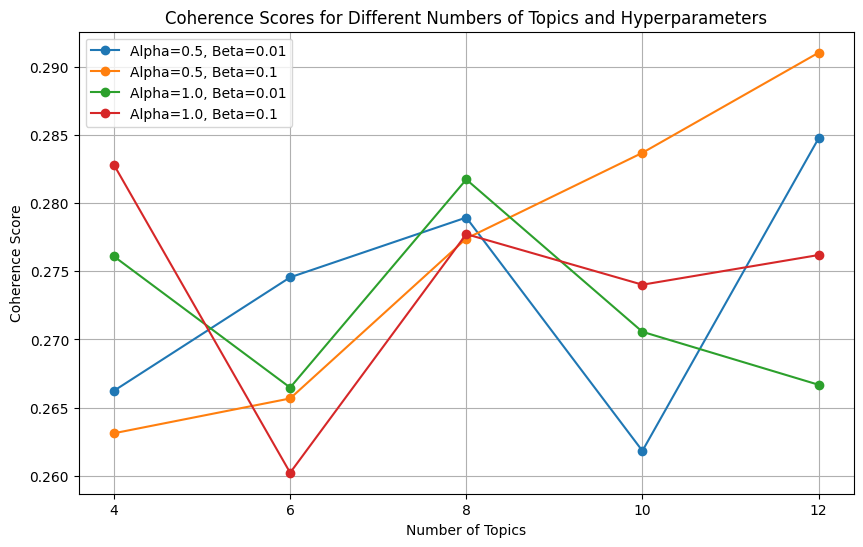

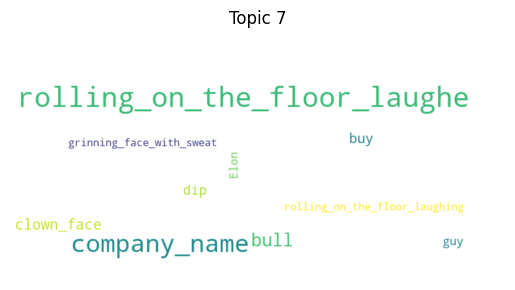

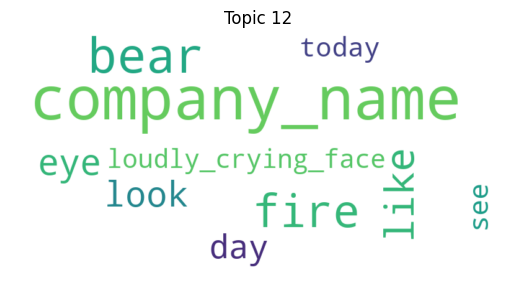

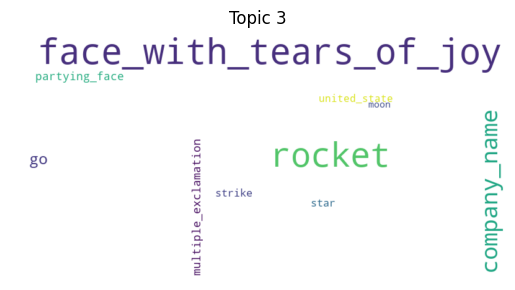

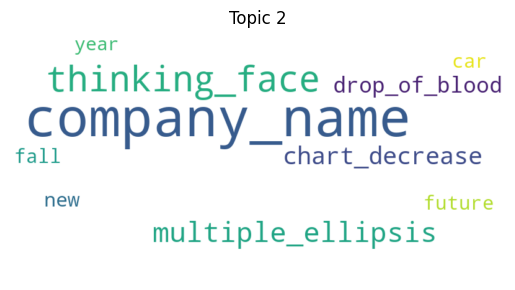

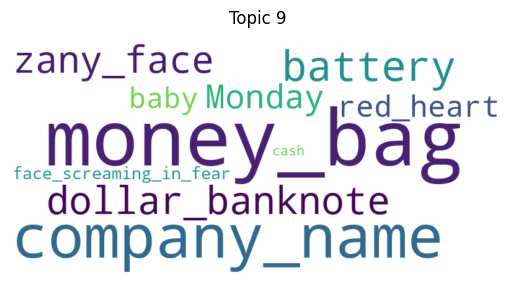

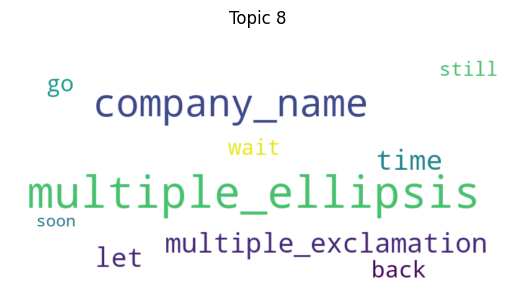

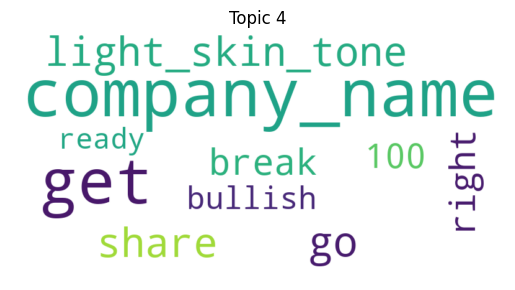

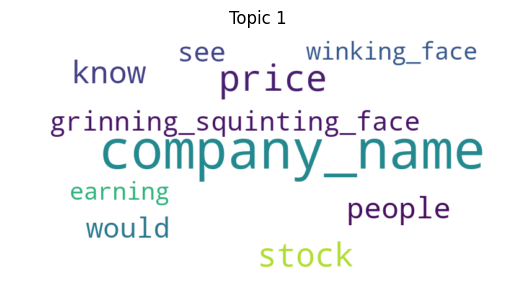

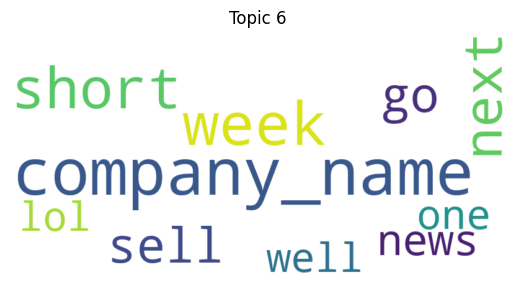

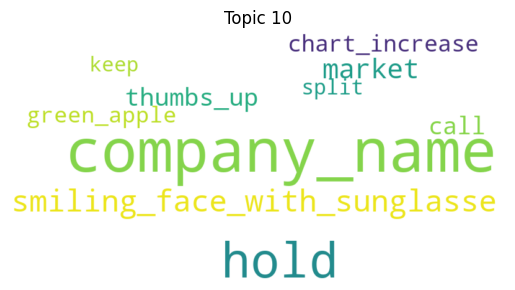

In [ ]:
from gensim.models import LdaModel
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re

stop_words = set(stopwords.words('english'))
custom_stop_words = {'COMPANY'}
stop_words.update(custom_stop_words)

def clean_text(text):
    text = re.sub(r'[^\w\s]', ' ', text)
    tokens = text.split()
    return [word for word in tokens if word.lower() not in stop_words]


texts = [clean_text(text) for text in train_df['lemmatized']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

def compute_coherence(lda_model, texts, dictionary):
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

num_topics_list = [4, 6, 8, 10, 12]
alpha_values = [0.5, 1.0]
beta_values = [0.01, 0.1]
coherence_scores = []
lda_models = {}

for alpha in alpha_values:
    for beta in beta_values:
        for n_topics in num_topics_list:
            lda = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary, random_state=42,
                           passes=10, alpha=alpha, eta=beta)
            lda_models[(n_topics, alpha, beta)] = lda
            coherence = compute_coherence(lda, texts, dictionary)
            coherence_scores.append((n_topics, alpha, beta, coherence))
best_model_params = max(coherence_scores, key=lambda x: x[3])
best_num_topics, best_alpha, best_beta, best_coherence = best_model_params
optimal_lda_model = lda_models[(best_num_topics, best_alpha, best_beta)]

print(f"Optimal number of topics: {best_num_topics}")
print(f"Optimal alpha: {best_alpha}")
print(f"Optimal beta: {best_beta}")

coherence_df = pd.DataFrame(coherence_scores, columns=['Num Topics', 'Alpha', 'Beta', 'Coherence'])
plt.figure(figsize=(10, 6))
for alpha in alpha_values:
    for beta in beta_values:
        subset = coherence_df[(coherence_df['Alpha'] == alpha) & (coherence_df['Beta'] == beta)]
        if not subset.empty:
            plt.plot(subset['Num Topics'], subset['Coherence'], marker='o', label=f"Alpha={alpha}, Beta={beta}")
plt.title('Coherence Scores for Different Numbers of Topics and Hyperparameters')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics_list)
plt.legend()
plt.grid()
plt.show()

def plot_word_clouds(lda_model):
    for topic_idx, topic in lda_model.show_topics(formatted=False):
        word_freq = {word: weight for word, weight in topic}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        plt.figure()
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {topic_idx + 1}")
    plt.show()

plot_word_clouds(optimal_lda_model)
visual_data = gensimvis.prepare(optimal_lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(visual_data)
pyLDAvis.save_html(visual_data, "lda_visualization.html")

In order to look for possible associations, the word clouds corresponding to the emotions are also plot.

In [ ]:
train_df

,emo_label,senti_label,original,processed,tfidf_emoji,tfidf_demojized,lemmatized
0,excitement,bullish,$AMZN Dow futures up by 100 points already 🥳,Amazon Dow futures up by 100 points already [partying face],company_name Dow futures up by 100 points already 🥳,company_name Dow futures up by 100 points already partying_face,company_name Dow future up by 100 point already partying_face
1,excitement,bullish,$TSLA Daddy's drinkin' eArly tonight! Here's to a PT of ohhhhh $1000 in 2020! 🍻,Tesla Daddy's drinkin' eArly tonight! Here's to a PT of ohhhhh $1000 in 2020! [clinking beer mugs],company_name Daddy's drinkin' eArly tonight! Here's to a PT of ohhhhh $1000 in 2020! 🍻,company_name Daddy's drinkin' eArly tonight! Here's to a PT of ohhhhh $1000 in 2020! clinking_beer_mugs,company_name daddy 's drinkin ' early tonight ! here be to a PT of ohhhhh $ 1000 in 2020 ! clinking_beer_mug
2,confusion,bullish,$AAPL We’ll been riding since last December from $172.12 what to do. Decisions decisions hmm 🤔. I have 20 mins to decide. Any suggestions?,Apple We’ll been riding since last December from $172.12 what to do. Decisions decisions hmm [thinking face] . I have 20 mins to decide. Any suggestions?,company_name We’ll been riding since last December from $172.12 what to do Decisions decisions hmm 🤔 I have 20 mins to decide Any suggestions?,company_name We’ll been riding since last December from $172.12 what to do Decisions decisions hmm thinking_face I have 20 mins to decide Any suggestions?,company_name we ’ll be ride since last December from $ 172.12 what to do decision decision hmm thinking_face I have 20 min to decide any suggestion ?
3,excitement,bullish,"$TSLA happy new year, 2020, everyone🍷🎉🙏","Tesla happy new year, 2020, everyone [wine glass] [party popper] [folded hands]",company_name happy new year 2020 everyone🍷🎉🙏,company_name happy new year 2020 everyone wine_glass party_popper folded_hands,company_name happy new year 2020 everyone wine_glass party_popper folded_hand
4,excitement,bullish,"$TSLA haha just a collection of greats...""Mars"" rofl 😈😎🌠⏫🔮💸👏💪🚀🎆🎇📣🎉🎊 *bork*","Tesla haha just a collection of greats...""Mars"" rofl [smiling face with horns] [smiling face with sunglasses] [shooting star] [fast up button] [crystal ball] [money with wings] [clapping hands] [flexed biceps] [rocket] [fireworks] [sparkler] [megaphone] [party popper] [confetti ball] *bork*",company_name haha just a collection of greats multiple_ellipsis Mars rofl 😈😎🌠⏫🔮💸👏💪🚀🎆🎇📣🎉🎊 *bork*,company_name haha just a collection of greats multiple_ellipsis Mars rofl smiling_face_with_horns smiling_face_with_sunglasses shooting_star fast_up_button crystal_ball money_with_wings clapping_hands flexed_biceps rocket fireworks sparkler megaphone party_popper confetti_ball *bork*,company_name haha just a collection of great multiple_ellipsis Mars rofl smiling_face_with_horn smiling_face_with_sunglasse shooting_star fast_up_button crystal_ball money_with_wing clapping_hand flexed_biceps rocket firework sparkler megaphone party_popper confetti_ball * bork *
...,...,...,...,...,...,...,...
7995,surprise,bullish,BREAKING NEWS: $AAPL beats Elon Musk and Richard Branson into space! 🚀📈 \n🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏,BREAKING NEWS: Apple beats Elon Musk and Richard Branson into space! [rocket] [chart increasing] \n [green apple],BREAKING NEWS company_name beats Elon Musk and Richard Branson into space! 🚀📈 🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏🍏,BREAKING NEWS company_name beats Elon Musk and Richard Branson into space! rocket chart_increasing green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple,break news company_name beat Elon Musk and Richard Branson into space ! rocket chart_increasing green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple green_apple gr

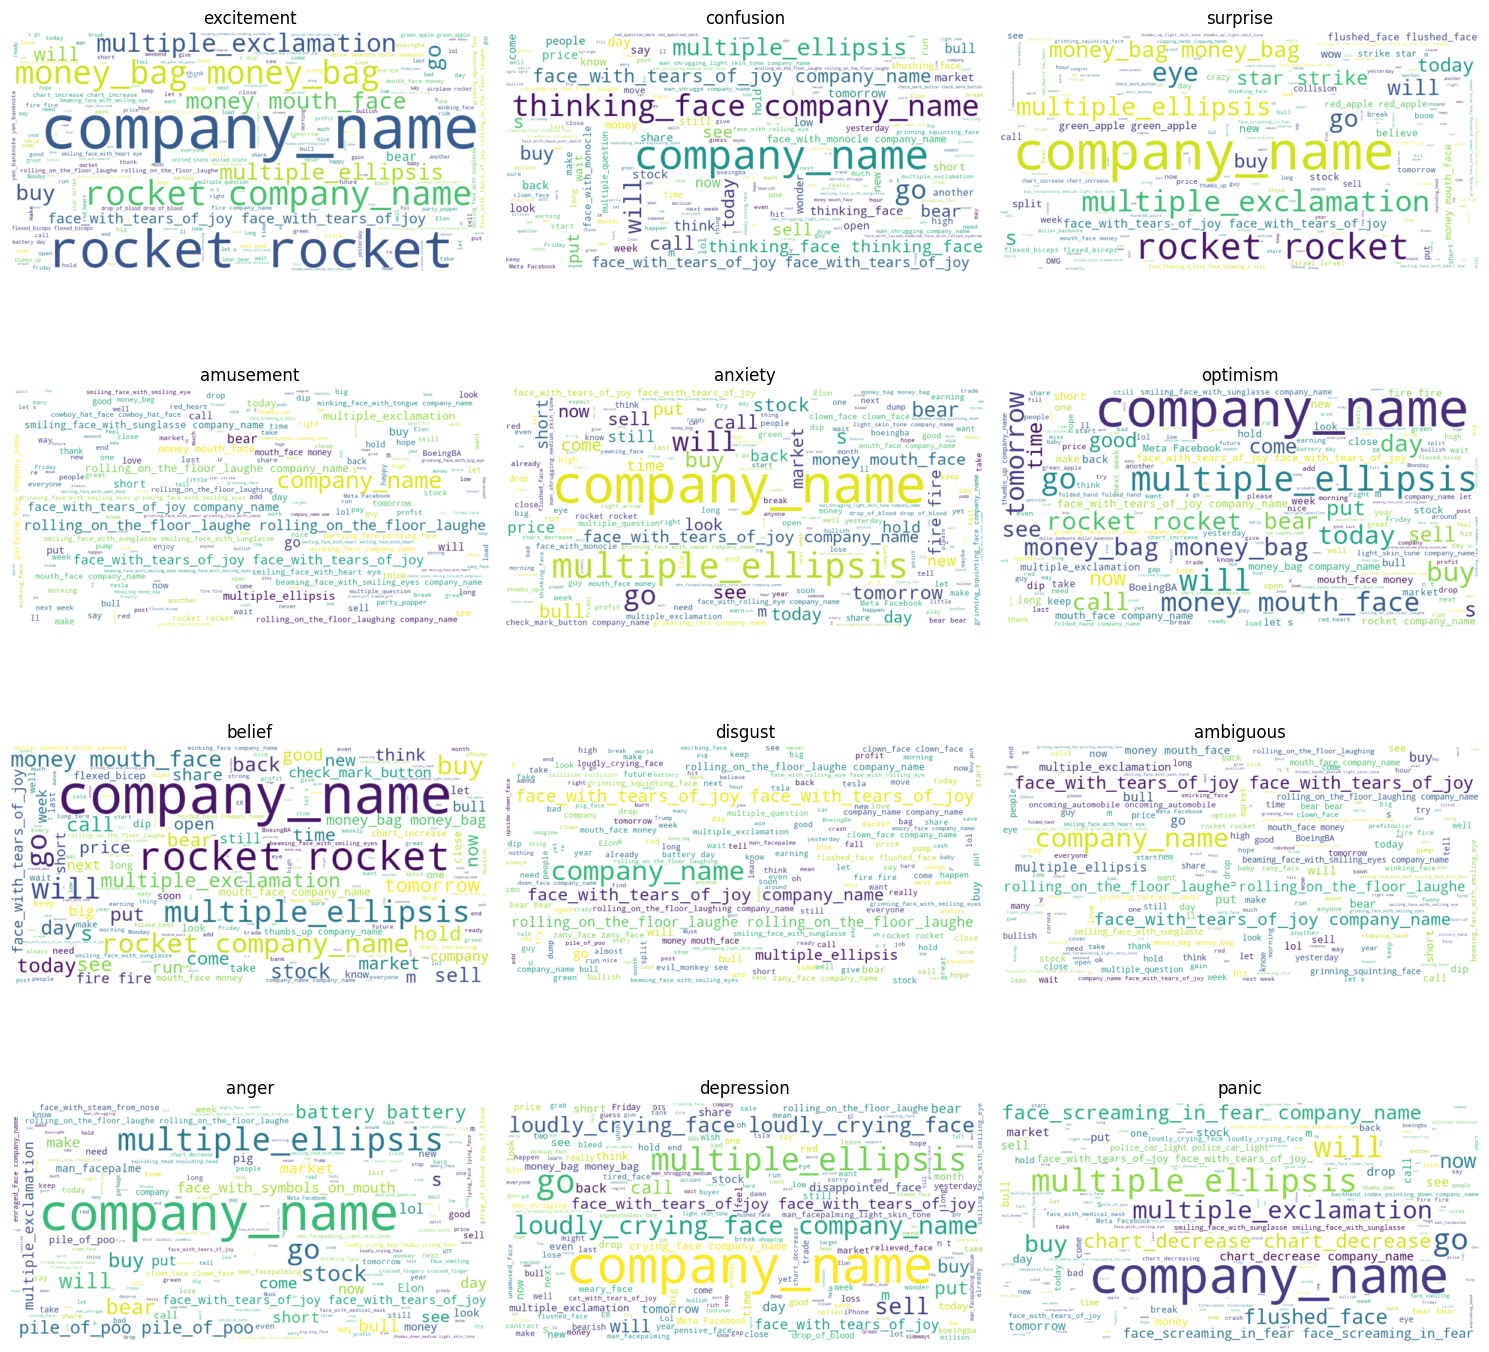

In [ ]:
grouped = train_df.groupby('emo_label')['lemmatized'].apply(' '.join)
plt.figure(figsize=(15, 15))
unique_labels = train_df['emo_label'].unique()

for i, label in enumerate(unique_labels):
    plt.subplot(4, 3, i + 1)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(grouped[label])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()